In [1]:
from matplotlib import pyplot as plt
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, MaxPooling1D, UpSampling1D
from keras.layers.convolutional import Conv1D, Conv2D
import medleydb as mdb
from scipy import signal
from scipy.io import wavfile

Using TensorFlow backend.


# Load the mix

In [2]:
multitracks = mdb.load_multitracks(["Phoenix_ColliersDaughter"])

In [3]:
mix = next(multitracks)

In [4]:
sample_rate, mix_audio = wavfile.read(mix.mix_path)
mix_audio = mix_audio.mean(1)
mix_audio = mix_audio[sample_rate*8:int(-sample_rate*1.5)]

In [5]:
samples_per_period = 256
overlap = 0

In [6]:
freqs, times, s_mix = signal.spectrogram(mix_audio, fs=sample_rate, mode="complex", nfft=samples_per_period, 
                                         noverlap=overlap, nperseg=samples_per_period)

freqs = freqs[:-1]
s_mix = s_mix[:-1,:]

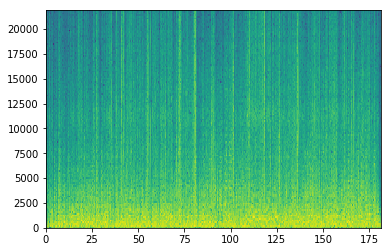

In [7]:
plt.pcolormesh(times, freqs, 20*np.log10(np.abs(s_mix)))

# Load the Flute

In [8]:
flutes = mdb.get_files_for_instrument("flute", [mix])

In [9]:
flute = next(flutes)

In [10]:
sample_rate, flute_audio = wavfile.read(flute)
flute_audio = flute_audio.mean(1)
flute_audio = flute_audio[sample_rate*8:int(-sample_rate*1.5)]

In [11]:
freqs, times, s_flute = signal.spectrogram(flute_audio, fs=sample_rate, mode="complex", nfft=samples_per_period, 
                                           noverlap=overlap, nperseg=samples_per_period)

freqs = freqs[:-1]
s_flute = s_flute[:-1,:]

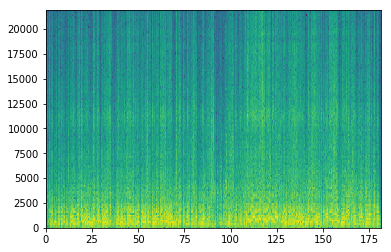

In [12]:
plt.pcolormesh(times, freqs, 20*np.log10(np.abs(s_flute)))

# Prepare the training data

In [22]:
#s_mix_train = s_mix.reshape(*s_mix.T.shape, 1)
#s_mix_train.shape

In [23]:
num_test  = int((sample_rate * 10)/samples_per_period)
num_train = s_mix.shape[1] - num_test
print(num_train, num_test)

29485 1722


In [24]:
mix_train = s_mix.T[:num_train,:,np.newaxis]
mix_train = np.concatenate((mix_train.real, mix_train.imag), axis=-1)
mix_train.shape

(29485, 128, 2)

In [25]:
flute_train = s_flute.T[:num_train,:,np.newaxis]
flute_train = np.concatenate((flute_train.real, flute_train.imag), axis=-1)
flute_train.shape

(29485, 128, 2)

In [26]:
mix_test = s_mix.T[-num_test:,:,np.newaxis]
mix_test = np.concatenate((mix_test.real, mix_test.imag), axis=-1)
mix_test.shape

(1722, 128, 2)

In [27]:
flute_test = s_flute.T[-num_test:,:,np.newaxis]
flute_test = np.concatenate((flute_test.real, flute_test.imag), axis=-1)
flute_test.shape

(1722, 128, 2)

In [58]:
model = Sequential()

model.add(Conv1D(16, 2, padding="same", input_shape=mix_train.shape[1:], activation="relu", name="Conv1D_1"))
model.add(MaxPooling1D(2, padding="same", name="MaxPooling_1"))

model.add(Conv1D(8, 2, padding="same",  activation="relu", name="Conv1D_2"))
model.add(MaxPooling1D(2, padding="same", name="MaxPooling_2"))

model.add(Conv1D(4, 2, padding="same",  activation="relu", name="Conv1D_3"))
model.add(MaxPooling1D(2, padding="same", name="MaxPooling_3"))

model.add(Conv1D(4, 2, padding="same",  activation="relu", name="Conv1D_4"))
model.add(UpSampling1D(2, name="UpSampling_1"))

model.add(Conv1D(8, 2, padding="same",  activation="relu", name="Conv1D_5"))
model.add(UpSampling1D(2, name="UpSampling_2"))

model.add(Conv1D(16, 2, padding="same",  activation="relu", name="Conv1D_6"))
model.add(UpSampling1D(2, name="UpSampling_3"))

model.add(Conv1D(2, 2, padding="same",  name="Conv1D_7"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Dense)             (None, 128, 64)           192       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 128, 2)            258       
Total params: 450
Trainable params: 450
Non-trainable params: 0
_________________________________________________________________


In [50]:
model.compile('adam', loss='mean_squared_error', metrics=['accuracy'])

In [51]:
history = model.fit(mix_train, flute_train, batch_size=200, epochs=10)

Epoch 1/10
29485/29485 [==============================] - 7s 229us/step - loss: 13.4343 - acc: 0.5009
Epoch 2/10
29485/29485 [==============================] - 6s 199us/step - loss: 13.4306 - acc: 0.5009
Epoch 3/10
29485/29485 [==============================] - 6s 198us/step - loss: 13.4276 - acc: 0.5012
Epoch 4/10
29485/29485 [==============================] - 6s 190us/step - loss: 13.4205 - acc: 0.5008
Epoch 5/10
29485/29485 [==============================] - 6s 196us/step - loss: 13.4185 - acc: 0.5010
Epoch 6/10
29485/29485 [==============================] - 6s 189us/step - loss: 13.4117 - acc: 0.5006
Epoch 7/10
29485/29485 [==============================] - 6s 194us/step - loss: 13.4072 - acc: 0.5009
Epoch 8/10
29485/29485 [==============================] - 6s 187us/step - loss: 13.4013 - acc: 0.5010
Epoch 9/10
29485/29485 [==============================] - 6s 189us/step - loss: 13.3998 - acc: 0.5007
Epoch 10/10
29485/29485 [==============================] - 6s 189us/step - loss: 1

In [47]:
results = model.evaluate(mix_test, flute_test)

print(model.metrics_names)
print(results)

1722/1722 [==============================] - 0s 235us/step
['loss', 'acc']
[12.348245417311977, 0.4999818525663236]


In [32]:
flute_prediction = model.predict(mix_test)
flute_prediction.shape

(1722, 128, 2)

In [33]:
flute_prediction = np.sqrt((flute_prediction**2).sum(-1)).T

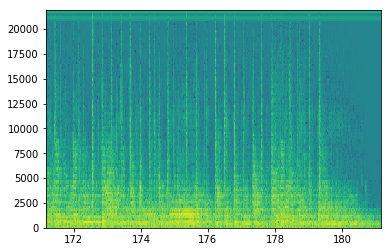

In [34]:
plt.pcolormesh(times[-num_test:], freqs[-num_test:], 20*np.log10(flute_prediction))

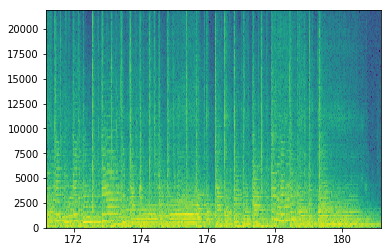

In [35]:
plt.pcolormesh(times[-num_test:], freqs[-num_test:], 20*np.log10(np.abs(s_mix[:,-num_test:])))

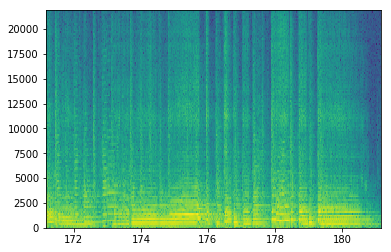

In [36]:
plt.pcolormesh(times[-num_test:], freqs[-num_test:], 20*np.log10(np.abs(s_flute[:,-num_test:])))